## Remaining Useful Life of NASA Turbofan Engine
Applt a machine learning model to predict the lifecycle of an engine and when it will likely fail, thus requiring maintenance. 


## Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Import the dataset

In [4]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = []
for i in range(1, 22):
    sensor_names.append('s_{}'.format(i))
col_names = index_names + setting_names + sensor_names

# Read the data
train = pd.read_csv('./data/train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('./data/test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('./data/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
y_test.shape

(100, 1)

In [6]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Calculate the Remaining Useful Life (RUL)

In [7]:
def calculate_rul(df):
    df = df.copy()
    df['RUL'] = df.groupby('unit_nr')['time_cycles'].transform('max') - df['time_cycles']
    return df

train = calculate_rul(train)

Normalize the features to improve model performance

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = col_names[2:]  # Skip 'unit_nr' and 'time_cycles'
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare training data
X = train[features]
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# We split up the train and test data

Train using linear regression

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)
model

LinearRegression()

Evaluate our model

In [12]:
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', mean_squared_error(y_val, y_pred))

Mean Absolute Error: 34.05029727923094
Mean Squared Error: 1966.2012639507047


Graph our model

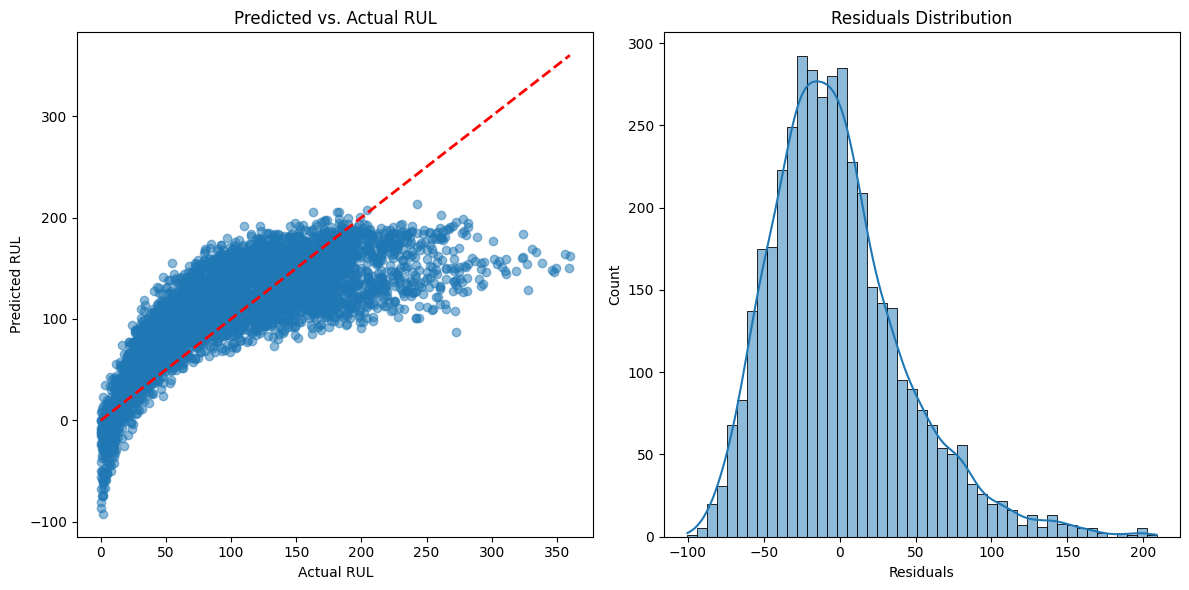

In [20]:
plt.figure(figsize=(12, 6))

# Scatter plot of predicted vs. actual values
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs. Actual RUL')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_val - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()
